<h1 style="color: #002B5B;">Main Heading 1</h1>
<h3 style="color: #0F52BA;">Subheading 1</h3> <!-- Sapphire Blue -->
<h3 style="color: #2F70C0;">Subheading 2</h3> <!-- Muted Blue -->
<h3 style="color: #5A9BD5;">Subheading 3</h3> <!-- Soft Professional Blue -->

<h1 style="color: #002B5B;">✬ Import and Install Dependencies</h1>

In [ ]:
import cv2
import math as math
import os
import mediapipe as mp
import re 
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.discriminant_analysis import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import load_model
from collections import deque
import time


2025-04-22 23:12:50.767977: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h1 style="color: #002B5B;">1. Dataset Extraction & Preprocessing</h1>

<h3 style="color: #0F52BA;">1.1 Extract Body Landmarks from Videos</h3>

<h4 style="color: #2F70C0;">1.1.1 Class and Functions to Collect The Exercise Features</h4>

This module uses MediaPipe to extract body landmarks from video frames, calculates key features (knee angle, heel-to-hip distance), determines the active side and leg state, counts exercise repetitions, evaluates posture, and provides detected landmarks visualization functions.

In [219]:
import cv2
import mediapipe as mp
import math
import numpy as np


class PostureChecker:
    def __init__(self, cap):
        """
        Initialize the PostureChecker.
        
        Sets up MediaPipe Pose for real-time pose detection, initializes drawing 
        utilities, defines a default heel-to-hip distance threshold for detecting 
        a "Pulled" state, and prepares counters and flags for repetition counting.
        Only one side (left or right) is processed depending on visibility.
        """
        
        # Initialize MediaPipe Pose for video processing.
        
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,       # Process video streams.
            model_complexity=2,            # Use higher complexity for better accuracy.
            min_detection_confidence=0.5,  # Minimum confidence threshold for detection.
            min_tracking_confidence=0.5    # Minimum confidence threshold for tracking.
        )
        
        # Initialize drawing utilities for visualizing landmarks.
        self.mp_drawing = mp.solutions.drawing_utils

        # Set default threshold for heel-to-hip distance (normalized).
        self.HEEL_TO_HIP_THRESHOLD = 0.2

        # Initialize repetition counters and flags for each leg.
        self.rep_count = {"Left": 0, "Right": 0}
        self.rep_started = {"Left": False, "Right": False}

        # Placeholders for baseline distance and active side (will be set later).
        self.baseline_distance = {"Left": None, "Right": None}
        self.active_side = None

        # Variables to store neck and torso inclination measurements.
        self.neck_inclination = None
        self.torso_inclination = None

    #-----------------------------------
    # Landmark Extraction
    #-----------------------------------
    
    def get_landmarks(self, frame):
        
        """
        Convert a BGR frame to RGB, process it with MediaPipe, and extract pose landmarks.
        
        Parameters:
            frame (numpy.ndarray): The input video frame.
            
        Returns:
            list: Detected pose landmarks, or None if no landmarks are found.
        """
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.pose.process(rgb_frame)
        return results.pose_landmarks.landmark if results.pose_landmarks else None

    #------------------------------------------
    # Determine Body Visibility
    #------------------------------------------
    
    def check_body_visibility(self, landmarks, min_visibility=0.7):
        """
        Check which side (left or right) of the body is visible based on landmark visibility.
        
        Parameters:
            landmarks (list): List of landmarks detected by MediaPipe.
            min_visibility (float): The minimum visibility score required for a landmark.
        
        Returns:
            str: "left_side", "right_side", or "not_visible" based on the visible landmarks.
        """
        
        # Landmark indices specific to each side.
        left_side_landmarks = [7, 11, 23, 25, 27, 29, 31]
        right_side_landmarks = [8, 12, 24, 26, 28, 30, 32]

        def are_landmarks_visible(required_landmarks):
            return all(
                landmarks[i] is not None and 
                landmarks[i].visibility >= min_visibility and 
                (0 <= landmarks[i].x <= 1 and 0 <= landmarks[i].y <= 1)
                for i in required_landmarks
            )

        if are_landmarks_visible(left_side_landmarks):
            return "left_side"
        elif are_landmarks_visible(right_side_landmarks):
            return "right_side"
        else:
            return "not_visible"

    #------------------------------------------
    # Distance Calculation
    #------------------------------------------
    
    def distance(self, lm1, lm2):
        """
        Compute the Euclidean distance between two landmarks using normalized coordinates.
        
        Parameters:
            lm1, lm2: Landmark objects with x and y attributes.
        
        Returns:
            float: The Euclidean distance.
        """
        return math.sqrt((lm1.x - lm2.x) ** 2 + (lm1.y - lm2.y) ** 2)

    #------------------------------------------
    # Knee Angle Calculation
    #------------------------------------------
    
    def calculate_knee_angle(self, landmarks, side):
        """
        Calculate the knee joint angle using the hip, knee, and ankle landmarks from the given side.
        
        Parameters:
            landmarks (list): List of detected landmarks.
            side (str): "left_side" or "right_side".
        
        Returns:
            float: The calculated knee angle in degrees, or None if the side is not specified.
        """
        if side == "left_side":
            hip = landmarks[self.mp_pose.PoseLandmark.LEFT_HIP.value]
            knee = landmarks[self.mp_pose.PoseLandmark.LEFT_KNEE.value]
            ankle = landmarks[self.mp_pose.PoseLandmark.LEFT_ANKLE.value]
        elif side == "right_side":
            hip = landmarks[self.mp_pose.PoseLandmark.RIGHT_HIP.value]
            knee = landmarks[self.mp_pose.PoseLandmark.RIGHT_KNEE.value]
            ankle = landmarks[self.mp_pose.PoseLandmark.RIGHT_ANKLE.value]
        else:
            return None
        a = np.array([hip.x, hip.y])
        b = np.array([knee.x, knee.y])
        c = np.array([ankle.x, ankle.y])
        ba = a - b
        bc = c - b
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))
        return angle

    #------------------------------------------
    # Repetition Counting (Update Rep Count)
    #------------------------------------------
    
    def update_rep_count(self, landmarks, timestamp):
        """
        Update the repetition count based on the heel-to-hip distance.
        If the distance falls below the threshold (indicating a "Pulled" state) and the rep is not active,
        increment the rep counter.
        When the distance returns above the threshold (indicating a "Rest" state), reset the rep flag.
        
        Parameters:
            landmarks (list): List of detected landmarks.
            timestamp (float): The current timestamp of the frame.
        """
        if self.active_side is None:
            return

        # Determine which leg to process.
        leg = "Left" if self.active_side == "left_side" else "Right"

        try:
            if leg == "Left":
                hip = landmarks[self.mp_pose.PoseLandmark.LEFT_HIP.value]
                heel = landmarks[self.mp_pose.PoseLandmark.LEFT_HEEL.value]
            else:
                hip = landmarks[self.mp_pose.PoseLandmark.RIGHT_HIP.value]
                heel = landmarks[self.mp_pose.PoseLandmark.RIGHT_HEEL.value]
        except (IndexError, TypeError):
            return

        dist = self.distance(hip, heel)

        # If the distance is below the threshold and a rep hasn't started, count the rep.
        if dist < self.HEEL_TO_HIP_THRESHOLD and not self.rep_started[leg]:
            self.rep_count[leg] += 1
            self.rep_started[leg] = True
            
        # When the leg extends, reset the rep flag.
        if dist >= self.HEEL_TO_HIP_THRESHOLD and self.rep_started[leg]:
            self.rep_started[leg] = False

    #------------------------------------------
    # Retrieve Heel-to-Hip Distance
    #------------------------------------------
    
    def get_distance(self, landmarks, leg):
        """
        Return the normalized heel-to-hip distance for the specified leg.
        
        Parameters:
            landmarks (list): List of detected landmarks.
            leg (str): "Left" or "Right".
        
        Returns:
            float: The calculated distance, or None if not computable.
        """
        try:
            if leg == "Left":
                hip = landmarks[self.mp_pose.PoseLandmark.LEFT_HIP.value]
                heel = landmarks[self.mp_pose.PoseLandmark.LEFT_HEEL.value]
            else:
                hip = landmarks[self.mp_pose.PoseLandmark.RIGHT_HIP.value]
                heel = landmarks[self.mp_pose.PoseLandmark.RIGHT_HEEL.value]
        except (IndexError, TypeError):
            return None
        return self.distance(hip, heel)

    #------------------------------------------
    # Determine Leg State (Pulled or Rest)
    #------------------------------------------
    
    def get_leg_state(self, distance_value):
        """
        Determine whether the leg is in the "Pulled" or "Rest" state based on the heel-to-hip distance.
        
        Parameters:
            distance_value (float): The computed heel-to-hip distance.
        
        Returns:
            str: "Pulled" if the distance is below the threshold, otherwise "Rest".
        """
        if distance_value is None:
            return "N/A"
        return "Pulled" if distance_value < self.HEEL_TO_HIP_THRESHOLD else "Rest"

    #------------------------------------------
    # Calculate Posture Angles (Neck and Torso)
    #------------------------------------------
    
    def find_posture_angle(self, x1, y1, x2, y2):
        """
        Calculate the angle (in degrees) between two points using a custom formula.
        
        This function is used to derive the neck and torso inclinations.
        
        Parameters:
            x1, y1: Coordinates of the first point.
            x2, y2: Coordinates of the second point.
        
        Returns:
            int: The computed angle in degrees.
        """
        theta = math.acos((y2 - y1) * (-y1) / (math.sqrt((x2 - x1)**2 + (y2 - y1)**2) * y1))
        return int((180 / math.pi) * theta)

    #------------------------------------------
    # Evaluate Sitting Posture and Compute Inclinations
    #------------------------------------------
    
    def is_sitting_correctly(self, landmarks, side):
        """
        Assess the sitting posture based on neck and torso inclinations.
        Uses shoulder and ear to compute the neck inclination and hip and shoulder for the torso inclination.
        
        Parameters:
            landmarks (list): List of detected landmarks.
            side (str): "left_side" or "right_side".
        
        Returns:
            tuple: (posture, neck_inclination, torso_inclination), where:
                   posture: "Good Posture" if neck < 40° and torso < 10°, else "Bad Posture".
                   neck_inclination: Computed neck inclination angle in degrees.
                   torso_inclination: Computed torso inclination angle in degrees.
        """
        if not landmarks:
            return "Bad Posture", None, None
        
        if side == "right_side":
            right_ear = landmarks[self.mp_pose.PoseLandmark.RIGHT_EAR.value]
            right_shoulder = landmarks[self.mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
            right_hip = landmarks[self.mp_pose.PoseLandmark.RIGHT_HIP.value]
            neck_inclination = self.find_posture_angle(right_shoulder.x, right_shoulder.y, right_ear.x, right_ear.y)
            torso_inclination = self.find_posture_angle(right_hip.x, right_hip.y, right_shoulder.x, right_shoulder.y)
        else:
            left_ear = landmarks[self.mp_pose.PoseLandmark.LEFT_EAR.value]
            left_shoulder = landmarks[self.mp_pose.PoseLandmark.LEFT_SHOULDER.value]
            left_hip = landmarks[self.mp_pose.PoseLandmark.LEFT_HIP.value]
            neck_inclination = self.find_posture_angle(left_shoulder.x, left_shoulder.y, left_ear.x, left_ear.y)
            torso_inclination = self.find_posture_angle(left_hip.x, left_hip.y, left_shoulder.x, left_shoulder.y)
        
        posture = "Good Posture" if neck_inclination < 40 and torso_inclination < 10 else "Bad Posture"
        return posture, neck_inclination, torso_inclination

    #------------------------------------------
    # Visualize Detected Landmarks
    #------------------------------------------
    
    def draw_landmarks(self, frame, results):
        """
        Draw the detected pose landmarks on the frame and highlight the heel for the active side 
        with concentric red circles. This is used for visualization and debugging.
        
        Parameters:
            frame (numpy.ndarray): The current video frame.
            results: The pose detection results from MediaPipe.
        """
        if results.pose_landmarks:
            # Draw all pose landmarks and connections.
            self.mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp.solutions.pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(
                    color=(200, 200, 200), thickness=1, circle_radius=1
                ),
                connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(
                    color=(150, 150, 150), thickness=1
                )
            )
            # Highlight the heel of the active side.
            if self.active_side == "left_side":
                heel_lm = results.pose_landmarks.landmark[self.mp_pose.PoseLandmark.LEFT_HEEL.value]
            elif self.active_side == "right_side":
                heel_lm = results.pose_landmarks.landmark[self.mp_pose.PoseLandmark.RIGHT_HEEL.value]
            else:
                return
            x = int(heel_lm.x * frame.shape[1])
            y = int(heel_lm.y * frame.shape[0])
            cv2.circle(frame, (x, y), 12, (0, 0, 255), 3)  # Draw outer red circle.
            cv2.circle(frame, (x, y), 6, (0, 0, 255), -1)  # Draw inner filled red circle.

    #------------------------------------------
    # Compute Detection Quality
    #------------------------------------------
    
    def detection_quality(self, landmarks):
        """
        Compute the average visibility of key landmarks (hip and heel) for the active side.
        
        Returns a value between 0 and 1 indicating detection quality.
        
        Parameters:
            landmarks (list): List of detected landmarks.
        
        Returns:
            float: The average visibility score.
        """
        visibilities = []
        try:
            if self.active_side == "left_side":
                left_hip = landmarks[self.mp_pose.PoseLandmark.LEFT_HIP.value]
                left_heel = landmarks[self.mp_pose.PoseLandmark.LEFT_HEEL.value]
                visibilities.extend([left_hip.visibility, left_heel.visibility])
            elif self.active_side == "right_side":
                right_hip = landmarks[self.mp_pose.PoseLandmark.RIGHT_HIP.value]
                right_heel = landmarks[self.mp_pose.PoseLandmark.RIGHT_HEEL.value]
                visibilities.extend([right_hip.visibility, right_heel.visibility])
        except Exception:
            return 0
        return sum(visibilities) / len(visibilities) if visibilities else 0

#------------------------------------------
# Utility: Overlay Avatar on Frame 
#------------------------------------------

def overlay_avatar(frame, avatar_img, x_offset=0, y_offset=0):
    """
    Overlay a given avatar image onto the current frame at the specified offset.
    
    Parameters:
        frame (numpy.ndarray): The video frame.
        avatar_img (numpy.ndarray): The avatar image to overlay.
        x_offset (int): Horizontal offset for the overlay.
        y_offset (int): Vertical offset for the overlay.
        
    Returns:
        numpy.ndarray: The frame with the avatar overlay.
    """
    if avatar_img is None:
        return frame
    h, w, _ = frame.shape
    ah, aw, _ = avatar_img.shape
    if y_offset + ah > h:
        ah = h - y_offset
    if x_offset + aw > w:
        aw = w - x_offset
    roi = frame[y_offset:y_offset+ah, x_offset:x_offset+aw]
    avatar_roi = avatar_img[0:ah, 0:aw]
    roi[:] = avatar_roi
    return frame


<h4 style="color: #2F70C0;">1.1.2 Process The Videos to Extract The Exercise Features </h4>

 Reads a video, processes each frame using the PostureChecker class, and returns a DataFrame with the extracted features. <br/>
    The output dictionary for each frame contains the following keys:<br/>
      - frame_index: Sequential frame number.<br/>
      - timestamp: Time in seconds from the start of the video.<br/>
      - body_visibility: Which side is visible ("left_side", "right_side", or "not_visible").<br/>
      - sitting_posture: Evaluation of the posture ("Good Posture" or "Bad Posture").<br/>
      - leg: Active leg ("Left" or "Right").<br/>
      - leg_status: Leg state determined by heel-to-hip distance ("Pulled" or "Rest").<br/>
      - knee_angle: Calculated knee angle in degrees.<br/>
      - distance: Normalized heel-to-hip distance.<br/>
      - rep_count: Number of repetitions recorded for the active side.<br/>
      - neck_inclination: Neck inclination angle in degrees.<br/>
      - torso_inclination: Torso inclination angle in degrees.<br/>
      - exercise_type: The type of exercise ("Heel Exercise").<br/>
      - video_path: Video file name.<br/>
    Returns:<br/>
        A Pandas DataFrame containing the extracted features for all processed frames.

In [220]:
def process_video(video_path, output_file=None):
    
    """
    Iterates through all videos, extracts posture data,
    and returns a combined pandas DataFrame.
    """
    
    # ---------------------------------------------------------------------------
    #  Initialization and Metadata Extraction
    # ---------------------------------------------------------------------------
    
    # Create an instance of PostureChecker using the video path.
    posture_checker = PostureChecker(video_path)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second of the video
    frame_data_list = []
    frame_number = 0

    # Set constant metadata
    exercise_type = "Heel Exercise"
    video_path = os.path.basename(video_path)  # Use only the file name
    filename = video_path

    # ---------------------------------------------------------------------------
    #  Process Each Frame in the Video
    # ---------------------------------------------------------------------------
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        timestamp = frame_number / fps if fps > 0 else None
        landmarks = posture_checker.get_landmarks(frame)

        # Initialize default values for each computed feature.
        rep_count = None
        visibility = "not_visible"
        leg = "N/A"
        knee_angle = None
        distance_val = None
        leg_state = None
        posture, neck_inclination, torso_inclination = ("N/A", None, None)
        
        # ---------------------------------------------------------------------------
        #  Compute Features if Landmarks are Detected
        # ---------------------------------------------------------------------------
        
        if landmarks is not None:
            
            # 1: Check body visibility and set active_side.
            visibility = posture_checker.check_body_visibility(landmarks)
            posture_checker.active_side = visibility if visibility != "not_visible" else None

            # 2: Calculate knee angle for the active side.
            knee_angle = (posture_checker.calculate_knee_angle(landmarks, posture_checker.active_side)
                          if posture_checker.active_side else None)

            # 3: Update repetition count based on heel-to-hip distance and timestamp.
            posture_checker.update_rep_count(landmarks, timestamp)
            
            # 4: Determine the active leg.
            if posture_checker.active_side == "left_side":
                leg = "Left"
            elif posture_checker.active_side == "right_side":
                leg = "Right"
            else:
                leg = "N/A"

            # 5: Compute heel-to-hip distance and determine leg state.
            distance_val = (posture_checker.get_distance(landmarks, leg)
                            if posture_checker.active_side else None)
            leg_state = posture_checker.get_leg_state(distance_val)
            
            # 6: Compute posture metrics (posture evaluation, neck and torso inclinations).
            if posture_checker.active_side:
                posture, neck_inclination, torso_inclination = posture_checker.is_sitting_correctly(landmarks, posture_checker.active_side)
            
            # 7: Retrieve the current repetition count.
            if posture_checker.active_side == "left_side":
                rep_count = posture_checker.rep_count["Left"]
            elif posture_checker.active_side == "right_side":
                rep_count = posture_checker.rep_count["Right"]
            else:
                rep_count = None

        # ---------------------------------------------------------------------------
        # Build the Output Dictionary for the Current Frame
        # ---------------------------------------------------------------------------
        
        row_dict = {
            "frame_index": frame_number,
            "timestamp": timestamp,
            "body_visibility": visibility,
            "sitting_posture": posture,
            "leg": leg,
            "leg_status": leg_state,
            "knee_angle": knee_angle,
            "distance": distance_val,
            "rep_count": rep_count,
            "neck_inclination": neck_inclination,
            "torso_inclination": torso_inclination,
            "exercise_type": exercise_type,
            "video_path": video_path,
        }
        
        # ---------------------------------------------------------------------------
        # Store Landmark Coordinates and Visibility Values (Optional)
        # ---------------------------------------------------------------------------
        
        if landmarks is not None:
            for i, lm in enumerate(landmarks):
                row_dict[f"landmark_{i}_x"] = lm.x
                row_dict[f"landmark_{i}_y"] = lm.y
                row_dict[f"landmark_{i}_visibility"] = lm.visibility

        frame_data_list.append(row_dict)
        frame_number += 1

    # ---------------------------------------------------------------------------
    # Finalize and Save the Data
    # ---------------------------------------------------------------------------
    cap.release()
    df = pd.DataFrame(frame_data_list)
    
    if output_file:
        df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    
    return df

<h4 style="color: #2F70C0;">1.1.3 Extract The Data </h4>

In [ ]:
if __name__ == '__main__':
    
    # ---------------------------------------------------------------------------
    # Define the Video Folder and Accepted Extensions
    # ---------------------------------------------------------------------------
    
    video_folder = "Heel Exercise/data"  # Folder path containing the video files.
    video_extensions = (".avi")  # File extensions to process.

    # ---------------------------------------------------------------------------
    # Retrieve All Video File Paths in the Folder
    # ---------------------------------------------------------------------------
    
    video_files = [os.path.join(video_folder, f) for f in os.listdir(video_folder)
                   if f.lower().endswith(video_extensions)]
    
    # ---------------------------------------------------------------------------
    # Process Each Video Individually to Extract Features
    # ---------------------------------------------------------------------------
    
    all_dfs = []  # List to store DataFrames for each processed video.
    for video_file in video_files:
        print(f"Processing: {video_file}")
        
        # Process the video using the process_video function.
        df_video = process_video(video_file, output_file=None)
        all_dfs.append(df_video)
        
    # ---------------------------------------------------------------------------
    # Concatenate All Video DataFrames into a Single DataFrame
    # ---------------------------------------------------------------------------
    
    df_all = pd.concat(all_dfs, ignore_index=True)
    
    # ---------------------------------------------------------------------------
    # Save the Combined DataFrame to CSV and Pickle Files
    # ---------------------------------------------------------------------------
    
    output_folder = "output"  
    # Create the output folder if it doesn't already exist.
    os.makedirs(output_folder, exist_ok=True)
    # Define file paths for CSV and pickle files.
    csv_path = os.path.join(output_folder, "heel_exercise_data.csv")
    pkl_path = os.path.join(output_folder, "heel_exercise_data.pkl")
    
    # Save the combined DataFrame in both CSV and pickle formats.
    df_all.to_csv(csv_path, index=False)
    df_all.to_pickle(pkl_path)
    
    print(f"Combined data saved to {csv_path} and {pkl_path}")


Processing: Heel Exercise/data/Ac1_Eg8_R2_C.avi


I0000 00:00:1744678490.551425  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744678491.025298 1617716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744678491.449856 1617721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac1_Eg8_R4_C.avi


I0000 00:00:1744678592.883485  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744678593.157625 1620742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744678593.359504 1620745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac1_Eg8_R6_C.avi


I0000 00:00:1744678674.184804  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744678674.584122 1623346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744678674.860510 1623347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac1_Eg8_R1_C.avi


I0000 00:00:1744678785.546637  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744678785.908029 1626642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744678786.144031 1626641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac1_Eg8_R3_C.avi


I0000 00:00:1744678850.175019  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744678850.572856 1628660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744678850.853333 1628664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac1_Eg8_R5_C.avi


I0000 00:00:1744678948.472146  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744678948.854140 1631721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744678949.198785 1631721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac5_Eg8_R1_C.avi


I0000 00:00:1744679056.372651  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744679057.056595 1634905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744679057.284872 1634905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac2_Eg8_R1_C.avi


I0000 00:00:1744679146.124724  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744679146.488623 1637520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744679146.770081 1637520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac4_Eg8_R5_C.avi


I0000 00:00:1744679236.878117  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744679237.289833 1640218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744679237.576385 1640224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac3_Eg8_R5_C.avi


I0000 00:00:1744679321.137341  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744679321.502158 1642695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744679321.754098 1642695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac5_Eg8_R3_C.avi


I0000 00:00:1744679415.786132  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744679416.130579 1645506 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744679416.365335 1645512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac2_Eg8_R3_C.avi


I0000 00:00:1744679548.380263  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744679548.852467 1649809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744679549.160996 1649809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac3_Eg8_R1_C.avi


I0000 00:00:1744679641.580197  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744679641.876479 1652623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744679642.093273 1652623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac4_Eg8_R1_C.avi


I0000 00:00:1744679735.495451  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744679735.820271 1655316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744679736.050613 1655319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac3_Eg8_R3_C.avi


I0000 00:00:1744679823.298723  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744679823.611151 1658208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744679823.837526 1658208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac4_Eg8_R3_C.avi


I0000 00:00:1744679893.048581  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744679893.388065 1660266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744679893.600389 1660264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac2_Eg8_R5_C.avi


I0000 00:00:1744679985.048284  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744679985.354538 1663035 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744679985.557628 1663035 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac5_Eg8_R5_C.avi


I0000 00:00:1744680080.550687  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744680080.973901 1665901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744680081.202933 1665906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac3_Eg8_R4_C.avi


I0000 00:00:1744680170.214518  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744680170.662683 1668537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744680170.899870 1668542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac4_Eg8_R4_C.avi


I0000 00:00:1744680261.807221  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744680262.230223 1671648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744680262.503426 1671649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac2_Eg8_R2_C.avi


I0000 00:00:1744680357.360497  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744680357.706961 1674587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744680357.921283 1674589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac5_Eg8_R2_C.avi


I0000 00:00:1744680451.670168  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744680452.020553 1677388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744680452.249783 1677393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac3_Eg8_R6_C.avi


I0000 00:00:1744680548.193480  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744680548.579805 1680238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744680548.829788 1680238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac4_Eg8_R6_C.avi


I0000 00:00:1744680642.929311  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744680643.274704 1683011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744680643.518117 1683011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac4_Eg8_R2_C.avi


I0000 00:00:1744680747.701774  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744680748.099700 1686760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744680748.535018 1686760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac3_Eg8_R2_C.avi


I0000 00:00:1744680835.741842  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744680836.102084 1689492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744680836.337497 1689492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac5_Eg8_R4_C.avi


I0000 00:00:1744680931.039048  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744680931.363071 1692246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744680931.580602 1692246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac2_Eg8_R4_C.avi


I0000 00:00:1744681010.195233  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744681010.541951 1694901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744681010.767403 1694906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac5_Eg8_R6_C.avi


I0000 00:00:1744681087.143940  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744681087.539581 1697114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744681087.803201 1697115 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing: Heel Exercise/data/Ac2_Eg8_R6_C.avi


I0000 00:00:1744681164.134106  299394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-23.0.21), renderer: Intel(R) Iris(TM) Plus Graphics 645
W0000 00:00:1744681164.542648 1699353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744681164.796715 1699356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Combined data saved to output/extracted_data(heel).csv and output/extracted_data(heel).pkl


<h3 style="color: #0F52BA;">1.2 Dataset Information (Before Preprocessing)</h3>

In [ ]:
# ---------------------------------------------------------------------------
#  Load Combined Data from Pickle
# ---------------------------------------------------------------------------

# Load the extracted combined data from the pickle file.
df = pd.read_pickle("output/heel_exercise_data.pkl")

<h4 style="color: #2F70C0;">1.2.1 Dataset Details</h4>

In [223]:
# ---------------------------------------------------------------------------
# Display Dataset Details (Before Further Preprocessing)
# ---------------------------------------------------------------------------
print("=" * 50)
print("Dataset Details (Before Further Preprocessing):")
print(f"• Number of videos: {df['video_path'].nunique()} videos")
print(f"• Total frames: {len(df):,} frames")

# Calculate total repetitions by summing the maximum rep_count per video.
total_reps = df.groupby("video_path")["rep_count"].max().sum()
print(f"• Total repetitions: {int(total_reps)} reps")
print(f"• Time range: {df['timestamp'].min():.1f}s to {df['timestamp'].max():.1f}s")
print(f"• Average FPS: {len(df) / df['timestamp'].max():.1f}")

# ---------------------------------------------------------------------------
# Compute Global Means for All Videos (Overall Metrics)
# ---------------------------------------------------------------------------

# Filter based on leg_status
pulled_data = df[df["leg_status"] == "Pulled"]
rest_data = df[df["leg_status"] == "Rest"]

mean_knee_pulled_global = pulled_data["knee_angle"].mean()
mean_knee_rest_global = rest_data["knee_angle"].mean()
mean_distance_pulled_global = pulled_data["distance"].mean()
mean_distance_rest_global = rest_data["distance"].mean()

print(f"• Global Mean knee angle for 'Pulled' state: {mean_knee_pulled_global:.2f} degrees")
print(f"• Global Mean knee angle for 'Rest' state: {mean_knee_rest_global:.2f} degrees")
print(f"• Global Mean heel-to-hip distance for 'Pulled' state: {mean_distance_pulled_global:.4f} (normalized)")
print(f"• Global Mean heel-to-hip distance for 'Rest' state: {mean_distance_rest_global:.4f} (normalized)")

# ---------------------------------------------------------------------------
# Video Breakdown: Repetitions and Mean Metrics by Video
# ---------------------------------------------------------------------------
print("\nVideo Breakdown:")
print("-" * 80)
print(f"{'Video':<15} | {'Reps':<6} | {'Mean Knee (Pulled)':<18} | {'Mean Knee (Rest)':<16} | {'Mean Distance (Pulled)':<24} | {'Mean Distance (Rest)':<22}")
print("-" * 80)

# Group data by "video_path"
grouped = df.groupby("video_path")
for video, group in grouped:
    # Repetition count is taken as the maximum rep_count for the video.
    reps = group["rep_count"].max()
    
    # Filter frames for "Pulled" and "Rest" states for the current video.
    pulled_group = group[group["leg_status"] == "Pulled"]
    rest_group = group[group["leg_status"] == "Rest"]
    
    # Compute mean metrics for this video.
    video_mean_knee_pulled = pulled_group["knee_angle"].mean() if not pulled_group.empty else None
    video_mean_knee_rest = rest_group["knee_angle"].mean() if not rest_group.empty else None
    video_mean_distance_pulled = pulled_group["distance"].mean() if not pulled_group.empty else None
    video_mean_distance_rest = rest_group["distance"].mean() if not rest_group.empty else None
    
    print(f"{os.path.basename(video):<15} | {reps:<6} | "
          f"{video_mean_knee_pulled if video_mean_knee_pulled is not None else 'N/A':<18} | "
          f"{video_mean_knee_rest if video_mean_knee_rest is not None else 'N/A':<16} | "
          f"{video_mean_distance_pulled if video_mean_distance_pulled is not None else 'N/A':<24} | "
          f"{video_mean_distance_rest if video_mean_distance_rest is not None else 'N/A':<22}")


Dataset Details (Before Further Preprocessing):
• Number of videos: 30 videos
• Total frames: 21,589 frames
• Total repetitions: 154 reps
• Time range: 0.0s to 30.3s
• Average FPS: 711.7
• Global Mean knee angle for 'Pulled' state: 69.27 degrees
• Global Mean knee angle for 'Rest' state: 95.38 degrees
• Global Mean heel-to-hip distance for 'Pulled' state: 0.1549 (normalized)
• Global Mean heel-to-hip distance for 'Rest' state: 0.2439 (normalized)

Video Breakdown:
--------------------------------------------------------------------------------
Video           | Reps   | Mean Knee (Pulled) | Mean Knee (Rest) | Mean Distance (Pulled)   | Mean Distance (Rest)  
--------------------------------------------------------------------------------
Ac1_Eg8_R1_C.avi | 4.0    | 68.79294306884718  | 96.08014134838223 | 0.14116081937542452      | 0.22599921913438298   
Ac1_Eg8_R2_C.avi | 6.0    | 68.82073262089598  | 95.15035266634241 | 0.13898034150498273      | 0.22823309205347328   
Ac1_Eg8_R3_C.a

<h4 style="color: #2F70C0;">1.2.2 Dataset Columns</h4>

In [224]:
# ---------------------------------------------------------------------------
# 1.2.2 Dataset Columns
# ---------------------------------------------------------------------------

print("\n" + "=" * 50)
print("Dataset Columns:")

# Define a dictionary with detailed descriptions for each column, matching your data structure.
columns_details = {
    "frame_index": "Frame sequence number",
    "timestamp": "Time elapsed in seconds from the start of the video",
    "body_visibility": "Body visibility [left_side, right_side, not_visible]",
    "sitting_posture": "Posture status [Good Posture, Bad Posture]",
    "leg": "Active leg [Left, Right]",
    "leg_status": "Leg state [Pulled, Rest]",
    "knee_angle": "Knee angle in degrees",
    "distance": "Heel-to-hip distance (normalized)",
    "rep_count": "Completed repetitions (per video)",
    "neck_inclination": "Neck inclination angle in degrees",
    "torso_inclination": "Torso inclination angle in degrees",
    "exercise_type": "Exercise type (Heel Exercise)",
    "video_path": "Video file name",
    "landmark_*": ("For each landmark index i (e.g., 0-32), there are three columns: "
                   "landmark_i_x (normalized x-coordinate), "
                   "landmark_i_y (normalized y-coordinate), "
                   "landmark_i_visibility (detection confidence, 0 to 1)")
}

# Print each column and its description.
for col, desc in columns_details.items():
    print(f"- {col + ':':<25} {desc}")

print("\nDataFrame Head:")
print(df.head(10))



Dataset Columns:
- frame_index:              Frame sequence number
- timestamp:                Time elapsed in seconds from the start of the video
- body_visibility:          Body visibility [left_side, right_side, not_visible]
- sitting_posture:          Posture status [Good Posture, Bad Posture]
- leg:                      Active leg [Left, Right]
- leg_status:               Leg state [Pulled, Rest]
- knee_angle:               Knee angle in degrees
- distance:                 Heel-to-hip distance (normalized)
- rep_count:                Completed repetitions (per video)
- neck_inclination:         Neck inclination angle in degrees
- torso_inclination:        Torso inclination angle in degrees
- exercise_type:            Exercise type (Heel Exercise)
- video_path:               Video file name
- landmark_*:               For each landmark index i (e.g., 0-32), there are three columns: landmark_i_x (normalized x-coordinate), landmark_i_y (normalized y-coordinate), landmark_i_visibilit

<h4 style="color: #2F70C0;">1.2.3 Dataset Visualization (Before Preprocessing)</h4>

<h4 style="color:rgb(29, 75, 130);">Body Visibility Distribution</h4>

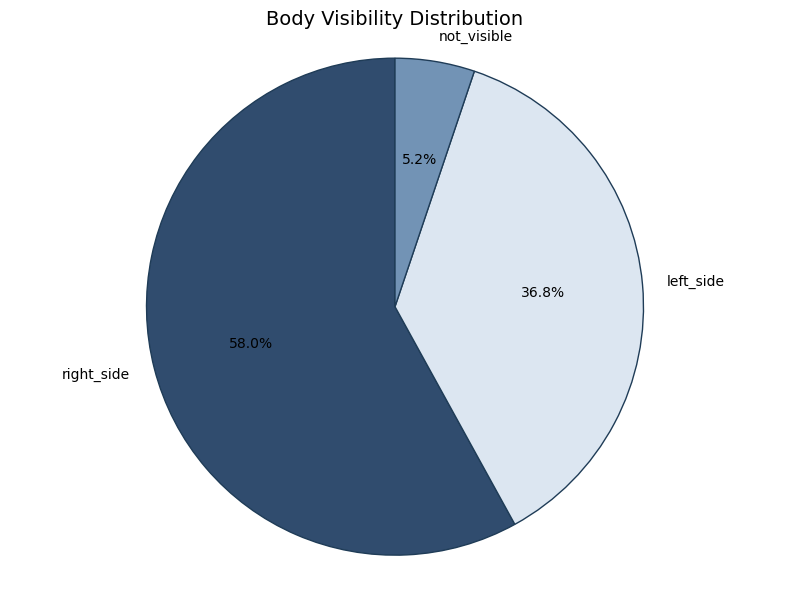

In [225]:
# Body Visibility Pie Chart
plt.figure(figsize=(8, 6))
visibility_counts = df['body_visibility'].value_counts()
plt.pie(visibility_counts, labels=visibility_counts.index, autopct='%1.1f%%',
        colors=['#304C6E', '#DCE6F1', '#7293B5'], startangle=90, wedgeprops={'edgecolor': '#1F3C57'})
plt.title('Body Visibility Distribution', fontsize=14)
plt.axis('equal')  # Ensure the pie chart is circular.
plt.tight_layout()
plt.show()

<p>
  This pie chart illustrates the distribution of the body's visible side across all frames in the dataset. 
  The three main categories are:
</p>

<h5>Left Side</h5>
<p>
  Represented by the green slice, indicating frames where the left side of the body is sufficiently visible to be detected.
</p>

<h5>Right Side</h5>
<p>
  Represented by the yellow slice, indicating frames where the right side of the body is sufficiently visible.
</p>

<h5>Not Visible</h5>
<p>
  A smaller slice corresponds to frames where neither side of the body is clearly visible or the required landmarks are not detected.
</p>

<p>
  Overall, this chart shows that most frames have adequate visibility for at least one side of the body, with a relatively small percentage where visibility is insufficient.
</p>


<h4 style="color:rgb(29, 75, 130);">Knee Angle Distribution</h4>

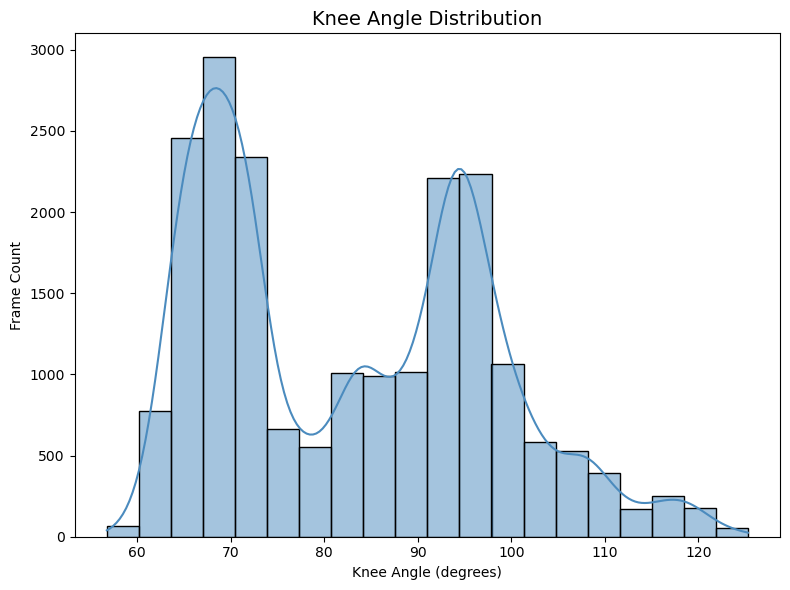

In [226]:
# Knee Angle Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['knee_angle'], bins=20, kde=True, color='#4B8BBE')
plt.title('Knee Angle Distribution', fontsize=14)
plt.xlabel('Knee Angle (degrees)')
plt.ylabel('Frame Count')
plt.tight_layout()
plt.show()


<h4>Diagram Description</h4>
<p>
  This diagram displays the distribution of the knee angle values across all frames using a histogram with an overlaid Kernel Density Estimation (KDE) curve.
</p>

<h5>Histogram:</h5>
<p>
  The histogram shows how many frames fall within specific ranges of knee angle values. Each bar represents the frequency (or count) of frames that have knee angles within that particular range. This gives a clear idea of the distribution and spread of knee angles in your data.
</p>

<h5>Kernel Density Estimation (KDE):</h5>
<p>
  The KDE is a smooth, continuous curve that is overlaid on top of the histogram. It provides an estimate of the probability density function (PDF) of the knee angle data. Instead of showing counts in discrete bins, the KDE smooths the distribution, helping to reveal the underlying pattern and indicate where the knee angles are most concentrated. This makes it easier to spot peaks (indicating high density) and troughs (indicating low density) in the distribution.
</p>

<h4 style="color:rgb(29, 75, 130);">Posture Percentage</h4>

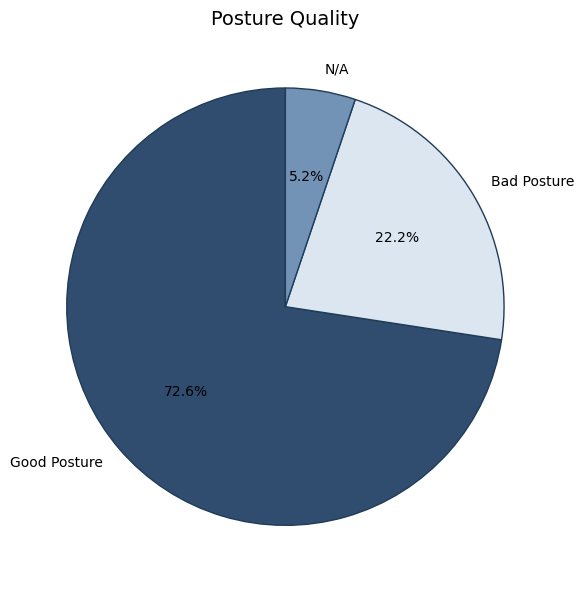

In [227]:
# Posture Percentage
plt.figure(figsize=(8, 6))
df['sitting_posture'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#304C6E', '#DCE6F1', '#7293B5'], startangle=90, wedgeprops={'edgecolor': '#1F3C57'})
plt.title('Posture Quality', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()


<p>
  This pie chart represents the distribution of sitting postures across all frames in the dataset. The data is divided into three main categories:
</p>

<h5>Good Posture</h5>
<p>
  Represented by the green segment, this category accounts for the majority of frames, indicating that most frames exhibit proper sitting posture.
</p>

<h5>Bad Posture</h5>
<p>
  Represented by the red segment, this category shows the percentage of frames where the posture deviates from acceptable standards.
</p>

<h5>N/A</h5>
<p>
  A small segment indicates frames where sufficient data was not available to determine the posture.
</p>

<p>
  Overall, the chart shows that most frames display good posture, while a smaller proportion show bad posture, and only a limited number of frames are marked as N/A due to missing or undefined data.
</p>

<h4 style="color:rgb(29, 75, 130);">Repetition Progression Over Time</h4>

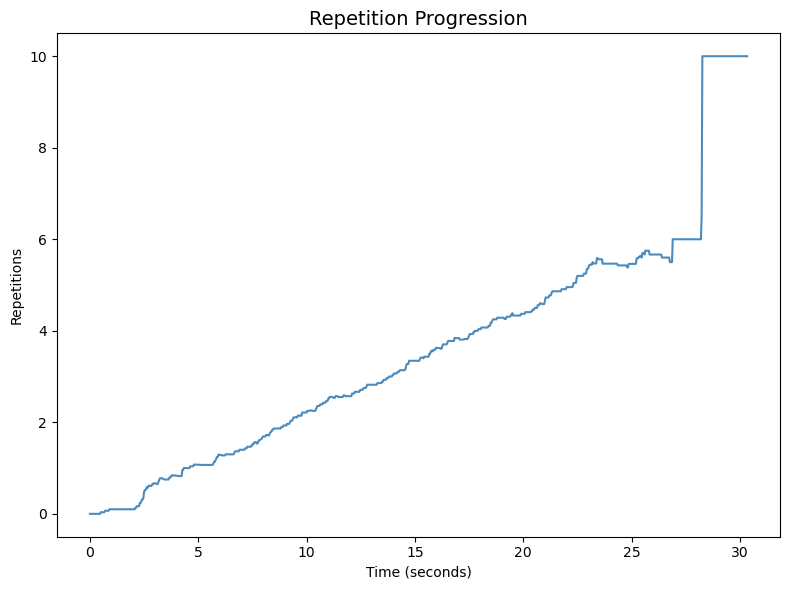

In [228]:
# Repetition Progression Over Time
plt.figure(figsize=(8, 6))
sns.lineplot(x='timestamp', y='rep_count', data=df, errorbar=None, color='#4B8BBE')
plt.title('Repetition Progression', fontsize=14)
plt.xlabel('Time (seconds)')
plt.ylabel('Repetitions')
plt.tight_layout()
plt.show()

<p>
  This line chart shows how the repetition count changes over time for the heel exercise. The x-axis represents time in seconds, while the y-axis represents the cumulative number of completed repetitions. 
</p>


<h4 style="color:rgb(29, 75, 130);">Heel-to-Hip Distance Distribution</h4>

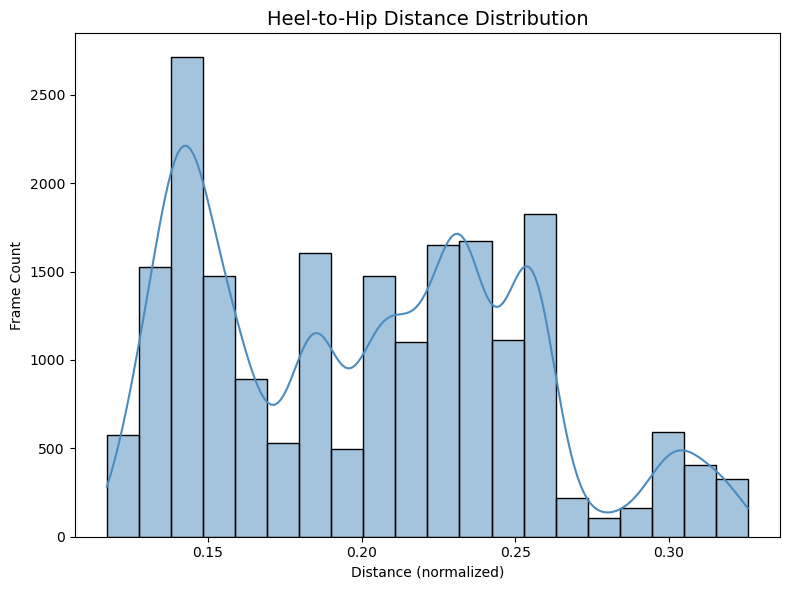

In [229]:
#  Heel-to-Hip Distance Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['distance'], bins=20, kde=True, color='#4B8BBE')
plt.title('Heel-to-Hip Distance Distribution', fontsize=14)
plt.xlabel('Distance (normalized)')
plt.ylabel('Frame Count')
plt.tight_layout()
plt.show()

<p>
  This histogram, overlaid with a Kernel Density Estimation (KDE) curve, illustrates the distribution of normalized heel-to-hip distance values observed across all frames in the dataset.
</p>

<h3 style="color: #0F52BA;">1.3 Data Preprocessing</h3>

<h4 style="color: #2F70C0;">1.3.1 Data Cleaning</h4>

In [ ]:
def clean_data(df):
    """
    Cleans the DataFrame for reliable LSTM input and subsequent video-level scoring.
    
    Steps:
      1. Remove frames where body_visibility is "not_visible".
      2. Drop rows with critical missing values in key features: 'knee_angle' and 'distance'.
      3. Remove outlier values in 'knee_angle' (set values < 0 or > 180 to NaN).
      4. Forward-fill missing values.
      5. Reset the index.
    
    Args:
        df (pd.DataFrame): The raw DataFrame extracted from videos.
    
    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """
    
    # ---------------------------------------------------------------------------
    # Remove frames where the body is not visible.
    # ---------------------------------------------------------------------------
    df = df[df["body_visibility"] != "not_visible"].copy()
    
    # ---------------------------------------------------------------------------
    # Drop rows with critical missing values in key features.
    # Here, we only require "knee_angle" and "distance" to be present.
    # ---------------------------------------------------------------------------
    df = df.dropna(subset=["knee_angle", "distance"])
    
    # ---------------------------------------------------------------------------
    #  Remove outliers in "knee_angle".
    #  Set values below 0 or above 180 degrees to NaN.
    # ---------------------------------------------------------------------------
    df.loc[(df["knee_angle"] < 0) | (df["knee_angle"] > 180), "knee_angle"] = np.nan
    
    # ---------------------------------------------------------------------------
    #  Forward-fill missing values to maintain data continuity.
    # ---------------------------------------------------------------------------
    df.ffill(inplace=True)
    
    # ---------------------------------------------------------------------------
    #  Reset the DataFrame index to ensure a continuous, clean index.
    # ---------------------------------------------------------------------------
    df.reset_index(drop=True, inplace=True)
    
    return df

# Display dataset information before and after cleaning.

print("=" * 50)
print("Dataset Details (Before Cleaning):")
df.info()  # Call without print() to avoid extra 'None'
print(f"Data shape before cleaning: {df.shape}\n")

df_clean = clean_data(df)

print("=" * 50)
print("Dataset Details (After Cleaning):")
df_clean.info()
print(f"Data shape after cleaning: {df_clean.shape}\n")



Dataset Details (Before Cleaning):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21589 entries, 0 to 21588
Columns: 112 entries, frame_index to landmark_32_visibility
dtypes: float64(105), int64(1), object(6)
memory usage: 18.4+ MB
Data shape before cleaning: (21589, 112)

Dataset Details (After Cleaning):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20472 entries, 0 to 20471
Columns: 112 entries, frame_index to landmark_32_visibility
dtypes: float64(105), int64(1), object(6)
memory usage: 17.5+ MB
Data shape after cleaning: (20472, 112)



<h4 style="color: #2F70C0;">1.3.3 One-Hot Encode</h4>

In [ ]:
# -----------------------------------------------------------------------------
# Function: encode_categorical
# -----------------------------------------------------------------------------
def encode_categorical(df, categorical_cols):
    """
    Applies one-hot encoding to specified categorical columns after filling missing values with the mode.
    
    Args:
        df (pd.DataFrame): The DataFrame to encode.
        categorical_cols (list): List of column names to one-hot encode.
    
    Returns:
        pd.DataFrame: The transformed DataFrame with one-hot encoded columns.
    """
    # Fill missing values in each categorical column with the mode of that column.
    for col in categorical_cols:
        if df[col].isnull().any():
            mode_value = df[col].mode()[0]
            df[col] = df[col].fillna(mode_value)
    
    # Initialize OneHotEncoder with settings for scikit-learn 1.2+.
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    
    # Fit the encoder to the specified categorical columns and transform the data.
    transformed = encoder.fit_transform(df[categorical_cols])
    
    # Generate new column names based on the encoder's categories.
    new_cols = []
    for col, cats in zip(categorical_cols, encoder.categories_):
        new_cols.extend([f"{col}_{cat}" for cat in cats])
    
    # Create a new DataFrame from the transformed data.
    df_ohe = pd.DataFrame(transformed, columns=new_cols, index=df.index)
    
    # Drop the original categorical columns from the DataFrame.
    df = df.drop(columns=categorical_cols)
    # Concatenate the new one-hot encoded columns with the remaining DataFrame.
    df = pd.concat([df, df_ohe], axis=1)
    
    return df

# -----------------------------------------------------------------------------
# Function: main
# -----------------------------------------------------------------------------
def main(df_clean):
    """
    Main function to one-hot encode specific categorical columns after filling missing values.
    
    The function encodes the following columns:
      - body_visibility: Indicates which side is visible ("left_side", "right_side", "not_visible")
      - sitting_posture: Posture status (e.g., "Good Posture", "Bad Posture")
      - leg: Active leg ("Left" or "Right")
      - leg_status: Derived leg state ("Pulled" or "Rest")
    
    Args:
        df_clean (pd.DataFrame): The input DataFrame that has been cleaned.
    
    Returns:
        pd.DataFrame: The DataFrame after applying one-hot encoding.
    """
    
    # Define the categorical columns to encode.
    categorical_cols = ["body_visibility", "sitting_posture", "leg", "leg_status"]
    
    # Apply one-hot encoding to these columns.
    df_encoded = encode_categorical(df_clean, categorical_cols=categorical_cols)
    
    print(f"After one-hot encoding: {df_encoded.shape}")
    return df_encoded

# -----------------------------------------------------------------------------
# Step: Load the Cleaned Data and Process It
# -----------------------------------------------------------------------------

df_final = main(df_clean)

# -----------------------------------------------------------------------------
# Save the Final Cleaned Data (After One-Hot Encoding)
# -----------------------------------------------------------------------------
output_folder = "output"
os.makedirs(output_folder, exist_ok=True)
csv_path = os.path.join(output_folder, "final_cleaned_data_heel.csv")
pkl_path = os.path.join(output_folder, "final_cleaned_data_heel.pkl")

# Save the DataFrame in CSV format (without including the index).
df_final.to_csv(csv_path, index=False)
# Save the DataFrame as a pickle file.
df_final.to_pickle(pkl_path)

print(f"Final cleaned data saved to {csv_path} and {pkl_path}")


After one-hot encoding: (20472, 116)
Final cleaned data saved to output/final_cleaned_data.csv and output/final_cleaned_data.pkl


In [ ]:
# -----------------------------------------------------------------------------
# 1. Load the Final Cleaned & One-Hot Encoded Data
# -----------------------------------------------------------------------------
df_clean = pd.read_pickle("output/final_cleaned_data_heel.pkl")


<h3 style="color: #0F52BA;">1.4 Dataset Information (After Preprocessing)</h3>

<h4 style="color: #2F70C0;">1.4.1 Dataset Details</h4>

In [233]:
# -----------------------------------------------------------------------------
#  Display Dataset Details (After Preprocessing)
# -----------------------------------------------------------------------------
print("=" * 50)
print("Dataset Details (After Preprocessing):")
print(f"• Number of videos: {df_clean['video_path'].nunique()} videos")
print(f"• Total frames: {len(df_clean):,} frames")

# Calculate total repetitions by summing the maximum rep_count for each video.
total_reps = df_clean.groupby("video_path")["rep_count"].max().sum()
print(f"• Total repetitions: {int(total_reps)} reps")
print(f"• Time range: {df_clean['timestamp'].min():.1f}s to {df_clean['timestamp'].max():.1f}s")
print(f"• Average FPS: {len(df_clean) / df_clean['timestamp'].max():.1f}")

# -----------------------------------------------------------------------------
# Compute Global Mean Metrics for All Videos (Overall Metrics)
# -----------------------------------------------------------------------------

# "leg_status_Pulled" equals 1 for frames in the "Pulled" state, and "leg_status_Rest" equals 1 for frames in the "Rest" state.
pulled_data = df_clean[df_clean["leg_status_Pulled"] == 1]
rest_data = df_clean[df_clean["leg_status_Rest"] == 1]

mean_knee_pulled_global = pulled_data["knee_angle"].mean()
mean_knee_rest_global = rest_data["knee_angle"].mean()
mean_distance_pulled_global = pulled_data["distance"].mean()
mean_distance_rest_global = rest_data["distance"].mean()

print("\nGlobal Mean Metrics:")
print(f"• Global Mean knee angle for 'Pulled' state: {mean_knee_pulled_global:.2f} degrees")
print(f"• Global Mean knee angle for 'Rest' state: {mean_knee_rest_global:.2f} degrees")
print(f"• Global Mean heel-to-hip distance for 'Pulled' state: {mean_distance_pulled_global:.4f} (normalized)")
print(f"• Global Mean heel-to-hip distance for 'Rest' state: {mean_distance_rest_global:.4f} (normalized)")

# -----------------------------------------------------------------------------
# Video Breakdown: Repetitions and Mean Metrics by Video
# -----------------------------------------------------------------------------

print("\nVideo Breakdown:")
print("-" * 80)
print(f"{'Video':<20} | {'Reps':<6} | {'Mean Knee (Pulled)':<18} | {'Mean Knee (Rest)':<16} | {'Mean Distance (Pulled)':<24} | {'Mean Distance (Rest)':<22}")
print("-" * 80)

# Group the data by the "video_path" column.
grouped = df_clean.groupby("video_path")
for video, group in grouped:
    # Use the maximum rep_count in the video as the total repetitions.
    reps = group["rep_count"].max()
    
    # Filter rows for "Pulled" and "Rest" states using the one-hot encoded columns.
    pulled_group = group[group["leg_status_Pulled"] == 1]
    rest_group = group[group["leg_status_Rest"] == 1]
    
    # Compute mean metrics for each state for the current video.
    video_mean_knee_pulled = pulled_group["knee_angle"].mean() if not pulled_group.empty else None
    video_mean_knee_rest = rest_group["knee_angle"].mean() if not rest_group.empty else None
    video_mean_distance_pulled = pulled_group["distance"].mean() if not pulled_group.empty else None
    video_mean_distance_rest = rest_group["distance"].mean() if not rest_group.empty else None
    
    print(f"{os.path.basename(video):<20} | {reps:<6} | "
          f"{video_mean_knee_pulled if video_mean_knee_pulled is not None else 'N/A':<18} | "
          f"{video_mean_knee_rest if video_mean_knee_rest is not None else 'N/A':<16} | "
          f"{video_mean_distance_pulled if video_mean_distance_pulled is not None else 'N/A':<24} | "
          f"{video_mean_distance_rest if video_mean_distance_rest is not None else 'N/A':<22}")


Dataset Details (After Preprocessing):
• Number of videos: 30 videos
• Total frames: 20,472 frames
• Total repetitions: 154 reps
• Time range: 0.0s to 30.3s
• Average FPS: 674.9

Global Mean Metrics:
• Global Mean knee angle for 'Pulled' state: 69.27 degrees
• Global Mean knee angle for 'Rest' state: 95.38 degrees
• Global Mean heel-to-hip distance for 'Pulled' state: 0.1549 (normalized)
• Global Mean heel-to-hip distance for 'Rest' state: 0.2439 (normalized)

Video Breakdown:
--------------------------------------------------------------------------------
Video                | Reps   | Mean Knee (Pulled) | Mean Knee (Rest) | Mean Distance (Pulled)   | Mean Distance (Rest)  
--------------------------------------------------------------------------------
Ac1_Eg8_R1_C.avi     | 4.0    | 68.79294306884718  | 96.08014134838223 | 0.14116081937542452      | 0.22599921913438298   
Ac1_Eg8_R2_C.avi     | 6.0    | 68.82073262089598  | 95.15035266634241 | 0.13898034150498273      | 0.228233092

<h4 style="color: #2F70C0;">1.4.2 Dataset Columns</h4>

In [234]:
print("\n" + "=" * 50)
print("Dataset Columns:")

# Dictionary containing the column names and their detailed descriptions.
columns_details = {
    "frame_index": "Frame sequence number",
    "timestamp": "Time elapsed in seconds from the start of the video",
    "knee_angle": "Knee angle in degrees",
    "distance": "Heel-to-hip distance (normalized)",
    "rep_count": "Completed repetitions (per video)",
    "neck_inclination": "Neck inclination angle in degrees",
    "torso_inclination": "Torso inclination angle in degrees",
    "exercise_type": "Exercise type (Heel Exercise)",
    "video_path": "Video file name",
    "landmark_*": ("For each landmark index i, there are three columns: "
                   "landmark_i_x (normalized x-coordinate), "
                   "landmark_i_y (normalized y-coordinate), "
                   "landmark_i_visibility (detection confidence, 0 to 1)"),
    "body_visibility_left_side": "One-hot encoded value indicating left side visibility (1 if left side is visible, else 0)",
    "body_visibility_right_side": "One-hot encoded value indicating right side visibility (1 if right side is visible, else 0)",
    "sitting_posture_Bad Posture": "One-hot encoded value for bad posture (1 if bad posture, else 0)",
    "sitting_posture_Good Posture": "One-hot encoded value for good posture (1 if good posture, else 0)",
    "leg_Left": "One-hot encoded value for active leg 'Left' (1 if the leg is 'Left', else 0)",
    "leg_Right": "One-hot encoded value for active leg 'Right' (1 if the leg is 'Right', else 0)",
    "leg_status_Pulled": "One-hot encoded value for leg state 'Pulled' (1 if pulled, else 0)",
    "leg_status_Rest": "One-hot encoded value for leg state 'Rest' (1 if rest, else 0)"
}

# Iterate through the dictionary and print each column along with its description.
for col, desc in columns_details.items():
    print(f"- {col + ':':<30} {desc}")

print("\nDataFrame Head:")
print(df.head(10))



Dataset Columns:
- frame_index:                   Frame sequence number
- timestamp:                     Time elapsed in seconds from the start of the video
- knee_angle:                    Knee angle in degrees
- distance:                      Heel-to-hip distance (normalized)
- rep_count:                     Completed repetitions (per video)
- neck_inclination:              Neck inclination angle in degrees
- torso_inclination:             Torso inclination angle in degrees
- exercise_type:                 Exercise type (Heel Exercise)
- video_path:                    Video file name
- landmark_*:                    For each landmark index i, there are three columns: landmark_i_x (normalized x-coordinate), landmark_i_y (normalized y-coordinate), landmark_i_visibility (detection confidence, 0 to 1)
- body_visibility_left_side:     One-hot encoded value indicating left side visibility (1 if left side is visible, else 0)
- body_visibility_right_side:    One-hot encoded value indicating

<h4 style="color: #2F70C0;">1.4.3 Dataset Visualization (After Preprocessing)</h4>

<h4 style="color:rgb(29, 75, 130);">Body Visibility Distribution</h4>

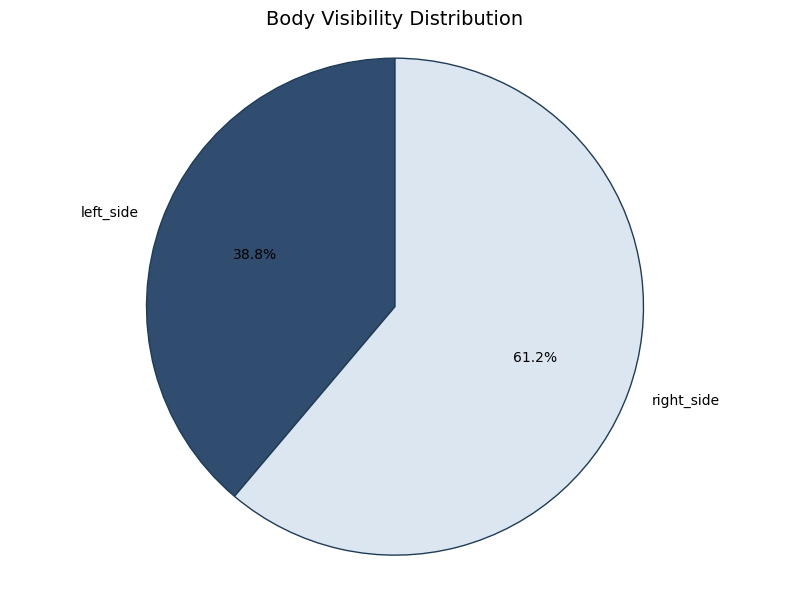

In [235]:
# Compute total counts from one-hot encoded body_visibility columns.
visibility_counts = {
    "left_side": df_clean["body_visibility_left_side"].sum(),
    "right_side": df_clean["body_visibility_right_side"].sum()
}

plt.figure(figsize=(8, 6))
plt.pie(list(visibility_counts.values()),
        labels=list(visibility_counts.keys()),
        autopct='%1.1f%%',
        colors=['#304C6E', '#DCE6F1', '#7293B5'],
        startangle=90,
        wedgeprops={'edgecolor': '#1F3C57'})
plt.title('Body Visibility Distribution', fontsize=14)
plt.axis('equal')  # Ensure the pie chart is circular.
plt.tight_layout()
plt.show()

<h4 style="color:rgb(29, 75, 130);">Knee Angle Distribution</h4>

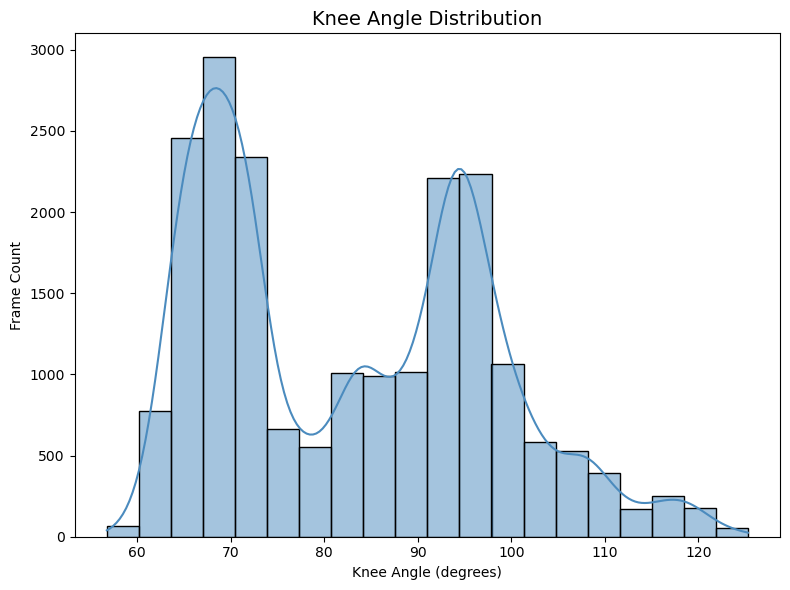

In [236]:
# Knee Angle Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df_clean['knee_angle'], bins=20, kde=True, color='#4B8BBE')
plt.title('Knee Angle Distribution', fontsize=14)
plt.xlabel('Knee Angle (degrees)')
plt.ylabel('Frame Count')
plt.tight_layout()
plt.show()


<h4 style="color:rgb(29, 75, 130);">Posture Percentage</h4>

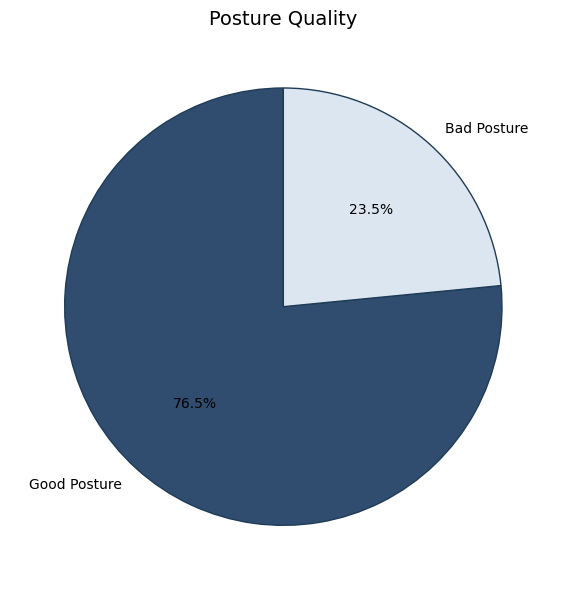

In [237]:
# Compute total counts for one-hot encoded posture columns.
posture_counts = {
    "Good Posture": df_clean["sitting_posture_Good Posture"].sum(),
    "Bad Posture": df_clean["sitting_posture_Bad Posture"].sum()
}

plt.figure(figsize=(8, 6))
plt.pie(list(posture_counts.values()),
        labels=list(posture_counts.keys()),
        autopct='%1.1f%%',
        colors=['#304C6E', '#DCE6F1'],
        startangle=90,
        wedgeprops={'edgecolor': '#1F3C57'})
plt.title('Posture Quality', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

<h4 style="color:rgb(29, 75, 130);">Repetition Progression Over Time</h4>

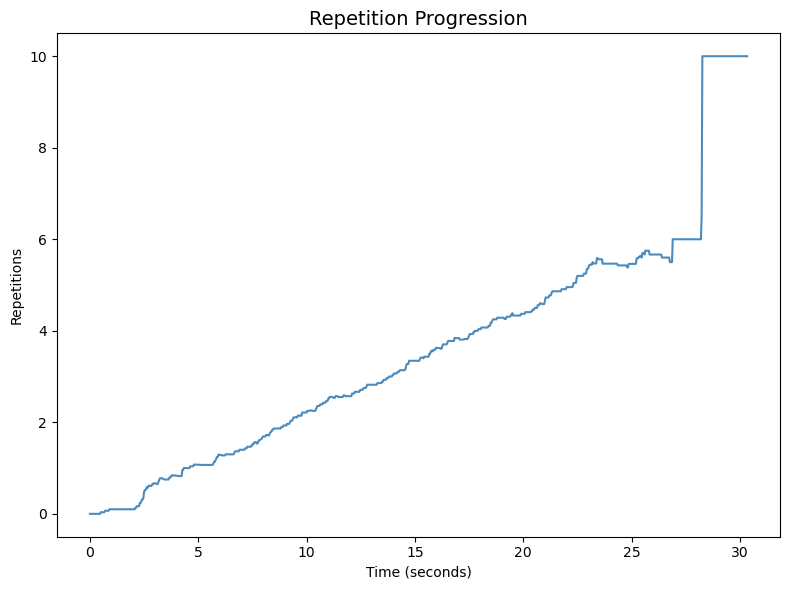

In [238]:
#  Repetition Progression Over Time
plt.figure(figsize=(8, 6))
sns.lineplot(x='timestamp', y='rep_count', data=df_clean, errorbar=None, color='#4B8BBE')
plt.title('Repetition Progression', fontsize=14)
plt.xlabel('Time (seconds)')
plt.ylabel('Repetitions')
plt.tight_layout()
plt.show()

<h4 style="color:rgb(29, 75, 130);">Heel-to-Hip Distance Distribution</h4>

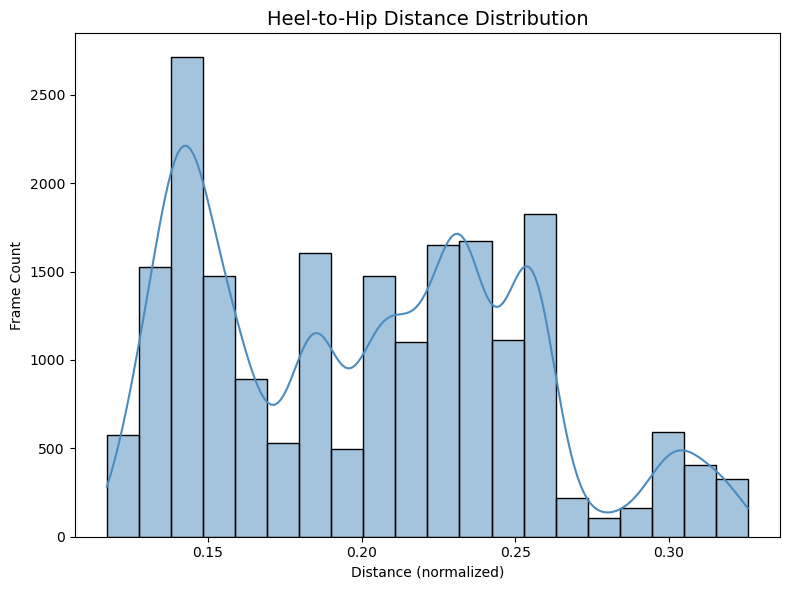

In [239]:
#  Heel-to-Hip Distance Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df_clean['distance'], bins=20, kde=True, color='#4B8BBE')
plt.title('Heel-to-Hip Distance Distribution', fontsize=14)
plt.xlabel('Distance (normalized)')
plt.ylabel('Frame Count')
plt.tight_layout()
plt.show()

<h3 style="color: #0F52BA;">1.5 Reshaping for LSTM Input</h3>

In [ ]:
# -----------------------------------------------------------------------------
#  Load the Final Cleaned & One-Hot Encoded Data
# -----------------------------------------------------------------------------
# The final cleaned data (after one-hot encoding) is stored in a pickle file.
# This DataFrame includes frame-level features and a "video_path" column that holds the video file name.
df_clean = pd.read_pickle("output/final_cleaned_data_heel.pkl")
print("Loaded final cleaned data. Shape:", df_clean.shape)

Loaded final cleaned data. Shape: (20472, 116)


<h4 style="color: #2F70C0;">1.5.1 Compute Ideal Values and Video-Level Performance Scores</h4>

<h5>Step 1: Deriving Ideal Values</h5>
<p>
  First, we compute the ideal (benchmark) values for our key metrics by separating the data into two phases:
  <strong>Pulled</strong> and <strong>Rest</strong>.
</p>
<ul>
  <li>
    <strong>Ideal Knee Angle (Pulled):</strong> The average knee angle across all frames where the leg is in the "Pulled" state.
  </li>
  <li>
    <strong>Ideal Knee Angle (Rest):</strong> The average knee angle across all frames where the leg is in the "Rest" state.
  </li>
  <li>
    <strong>Ideal Distance (Pulled):</strong> The average normalized heel-to-hip distance for frames in the "Pulled" state.
  </li>
  <li>
    <strong>Ideal Distance (Rest):</strong> The average normalized heel-to-hip distance for frames in the "Rest" state.
  </li>
</ul>
<p>
  These averages serve as our benchmarks for what is considered optimal in each phase.
</p>

<h5>Step 2: Computing Phase-Specific Errors</h5>
<p>
  For each video, we then compute the average values for both the knee angle and the heel-to-hip distance separately for the "Pulled" and "Rest" phases.
  Next, we calculate the absolute error for each metric as follows:
</p>
<ul>
  <li>
    <strong>Error in Knee Angle (Pulled):</strong> |Observed Pulled Knee Angle − Ideal Pulled Knee Angle|
  </li>
  <li>
    <strong>Error in Knee Angle (Rest):</strong> |Observed Rest Knee Angle − Ideal Rest Knee Angle|
  </li>
  <li>
    <strong>Error in Distance (Pulled):</strong> |Observed Pulled Distance − Ideal Pulled Distance|
  </li>
  <li>
    <strong>Error in Distance (Rest):</strong> |Observed Rest Distance − Ideal Rest Distance|
  </li>
</ul>
<p>
  We then compute the average error for each type (knee angle and distance) by averaging the errors obtained for the "Pulled" and "Rest" phases.
</p>

<h5>Step 3: Combining Errors and Mapping to a Performance Score</h5>
<p>
  Next, we combine the errors from the knee angle and the distance using weighted averaging:
</p>
<p>
  <strong>Combined Error (E):</strong> <br>
  E = (w<sub>knee</sub> × avg_error<sub>knee</sub>) + (w<sub>distance</sub> × avg_error<sub>distance</sub>)
  <br>
  <br>
  where:   
  <br>
  <ul>
    <li>w<sub>knee</sub> is the weight for the knee angle error.</li>
    <li>w<sub>distance</sub> is the weight for the distance error.</li>
  </ul>
</p>
<p>
  Finally, we map this combined error to a performance score on a scale of 0 to 100 using a linear equation:
</p>
<p>
  <strong>Performance Score:</strong> <br>
  Score = 100 × (1 − (E / E<sub>max</sub>))
  <br>
  where E<sub>max</sub> is the maximum error threshold (any error equal to or exceeding E<sub>max</sub> will yield a score of 0). The resulting score is then clamped between 0 and 100.
</p>

<h5>Overall Process</h5>
<p>
  In summary, we transform the raw continuous measurements (knee angle and heel-to-hip distance) into a performance score using the following procedure:
</p>
<ol>
  <li>
    <strong>Derive Ideal Values:</strong> Calculate the ideal (benchmark) averages for knee angle and distance in both "Pulled" and "Rest" phases.
  </li>
  <li>
    <strong>Compute Errors:</strong> For each video, determine the deviation (absolute error) of the observed averages from the ideal values.
  </li>
  <li>
    <strong>Combine Errors:</strong> Use a weighted average of the errors to obtain a combined error.
  </li>
  <li>
    <strong>Map to a Score:</strong> Convert the combined error to a performance score on a 0–100 scale, where a lower error results in a higher score.
  </li>
</ol>
<p>
  This process provides an outcome (performance score) that reflects how closely the exercise performed in each video adheres to the ideal benchmarks. 
</p>

In [5]:
# -----------------------------------------------------------------------------
# Function: compute_global_ideal_values
# -----------------------------------------------------------------------------
def compute_global_ideal_values(df):
    """
    Compute global ideal (benchmark) values for knee angle and heel-to-hip distance,
    separated by the "Pulled" and "Rest" states using the one-hot encoded columns.
    
    Uses:
      - 'leg_status_Pulled' (value 1 indicates Pulled)
      - 'leg_status_Rest' (value 1 indicates Rest)
    
    Returns:
      (ideal_knee_pulled, ideal_knee_rest, ideal_distance_pulled, ideal_distance_rest)
    """
    # Filter rows for each state directly.
    pulled_frames = df[df["leg_status_Pulled"] == 1]
    rest_frames = df[df["leg_status_Rest"] == 1]
    
    ideal_knee_pulled = pulled_frames["knee_angle"].mean() if not pulled_frames.empty else None
    ideal_knee_rest   = rest_frames["knee_angle"].mean() if not rest_frames.empty else None
    ideal_distance_pulled = pulled_frames["distance"].mean() if not pulled_frames.empty else None
    ideal_distance_rest   = rest_frames["distance"].mean() if not rest_frames.empty else None
    
    return ideal_knee_pulled, ideal_knee_rest, ideal_distance_pulled, ideal_distance_rest

# -----------------------------------------------------------------------------
# Function: compute_performance_score
# -----------------------------------------------------------------------------
def compute_performance_score(video_df, 
                              ideal_knee_pulled, ideal_knee_rest, 
                              ideal_distance_pulled, ideal_distance_rest, 
                              weight_knee=0.7, weight_distance=0.3, E_max=20):
    """
    Compute a performance score for one video by comparing the observed averages of 
    knee angle and heel-to-hip distance (in "Pulled" and "Rest" states) with the global ideal values.
    
    The observed averages are calculated using the one-hot encoded columns:
      - Rows with 'leg_status_Pulled' == 1 are in the "Pulled" state.
      - Rows with 'leg_status_Rest' == 1 are in the "Rest" state.
    
    The weighted combined error is mapped linearly to a performance score (0 to 100):
        score = 100 * (1 - (combined_error / E_max))
    
    Returns:
      A performance score (float) between 0 and 100.
    """
    pulled_frames = video_df[video_df["leg_status_Pulled"] == 1]
    rest_frames = video_df[video_df["leg_status_Rest"] == 1]
    
    pulled_knee_avg = pulled_frames["knee_angle"].mean() if not pulled_frames.empty else ideal_knee_pulled
    rest_knee_avg   = rest_frames["knee_angle"].mean() if not rest_frames.empty else ideal_knee_rest
    pulled_distance_avg = pulled_frames["distance"].mean() if not pulled_frames.empty else ideal_distance_pulled
    rest_distance_avg   = rest_frames["distance"].mean() if not rest_frames.empty else ideal_distance_rest
    
    error_knee_pulled = abs(pulled_knee_avg - ideal_knee_pulled)
    error_knee_rest   = abs(rest_knee_avg - ideal_knee_rest)
    error_distance_pulled = abs(pulled_distance_avg - ideal_distance_pulled)
    error_distance_rest   = abs(rest_distance_avg - ideal_distance_rest)
    
    avg_error_knee = (error_knee_pulled + error_knee_rest) / 2
    avg_error_distance = (error_distance_pulled + error_distance_rest) / 2
    
    combined_error = weight_knee * avg_error_knee + weight_distance * avg_error_distance
    score = 100 * (1 - (combined_error / E_max))
    score = max(0, min(100, score))
    
    return score

# Compute global ideal values using the cleaned data.
ideal_knee_pulled, ideal_knee_rest, ideal_distance_pulled, ideal_distance_rest = compute_global_ideal_values(df_clean)
print("\nGlobal Ideal Values:")
print(f"Ideal Knee Angle (Pulled): {ideal_knee_pulled:.2f}°")
print(f"Ideal Knee Angle (Rest): {ideal_knee_rest:.2f}°")
print(f"Ideal Heel-to-Hip Distance (Pulled): {ideal_distance_pulled:.4f}")
print(f"Ideal Heel-to-Hip Distance (Rest): {ideal_distance_rest:.4f}")

# Compute performance scores for each video by grouping using "video_path".
video_scores = {}
for video, group in df_clean.groupby("video_path"):
    score = compute_performance_score(group, 
                                      ideal_knee_pulled, ideal_knee_rest, 
                                      ideal_distance_pulled, ideal_distance_rest,
                                      weight_knee=0.7, weight_distance=0.3, E_max=20)
    video_scores[video] = score

print("\nPerformance Scores for Each Video:")
for vid, sc in video_scores.items():
    print(f"{vid}: {sc:.1f}")


Global Ideal Values:
Ideal Knee Angle (Pulled): 69.27°
Ideal Knee Angle (Rest): 95.38°
Ideal Heel-to-Hip Distance (Pulled): 0.1549
Ideal Heel-to-Hip Distance (Rest): 0.2439

Performance Scores for Each Video:
Ac1_Eg8_R1_C.avi: 97.9
Ac1_Eg8_R2_C.avi: 98.8
Ac1_Eg8_R3_C.avi: 97.8
Ac1_Eg8_R4_C.avi: 88.2
Ac1_Eg8_R5_C.avi: 92.2
Ac1_Eg8_R6_C.avi: 92.7
Ac2_Eg8_R1_C.avi: 75.6
Ac2_Eg8_R2_C.avi: 80.5
Ac2_Eg8_R3_C.avi: 77.3
Ac2_Eg8_R4_C.avi: 97.3
Ac2_Eg8_R5_C.avi: 97.7
Ac2_Eg8_R6_C.avi: 87.3
Ac3_Eg8_R1_C.avi: 84.5
Ac3_Eg8_R2_C.avi: 85.7
Ac3_Eg8_R3_C.avi: 86.3
Ac3_Eg8_R4_C.avi: 71.2
Ac3_Eg8_R5_C.avi: 71.5
Ac3_Eg8_R6_C.avi: 69.8
Ac4_Eg8_R1_C.avi: 87.8
Ac4_Eg8_R2_C.avi: 90.4
Ac4_Eg8_R3_C.avi: 88.6
Ac4_Eg8_R4_C.avi: 88.4
Ac4_Eg8_R5_C.avi: 88.4
Ac4_Eg8_R6_C.avi: 85.1
Ac5_Eg8_R1_C.avi: 88.4
Ac5_Eg8_R2_C.avi: 95.8
Ac5_Eg8_R3_C.avi: 96.6
Ac5_Eg8_R4_C.avi: 85.8
Ac5_Eg8_R5_C.avi: 85.0
Ac5_Eg8_R6_C.avi: 91.6


<h4 style="color: #2F70C0;">1.5.2 Reshaping the Data for LSTM Input</h4>

In [6]:
# -----------------------------------------------------------------------------
# Function: prepare_sequences_for_lstm
# -----------------------------------------------------------------------------
def prepare_sequences_for_lstm(df, sequence_length=700, feature_cols=None):
    """
    Reshape frame-level data into fixed-length sequences suitable for LSTM input.
    
    Process:
      1. Group data by "video_path" (which contains the video file name).
      2. Within each group, sort by "frame_index" to maintain temporal order.
      3. Select feature columns (if not provided, all columns except 'frame_index', 'timestamp', 'video_path', and 'exercise_type').
      4. For each video:
         - If the number of frames is less than sequence_length, pad the sequence with zeros.
         - If more, truncate to sequence_length.
    
    Args:
        df (pd.DataFrame): Preprocessed DataFrame (cleaned and one-hot encoded).
        sequence_length (int): Fixed number of frames per sequence.
        feature_cols (list, optional): List of columns to use as features.
    
    Returns:
        tuple: (X, video_ids)
            X: 3D NumPy array of shape (num_videos, sequence_length, num_features).
            video_ids: List of video file names corresponding to each sequence.
    """
    if feature_cols is None:
        exclude = {"frame_index", "timestamp", "video_path", "exercise_type"}
        feature_cols = [col for col in df.columns if col not in exclude]
    
    sequences = []
    video_ids = []
    
    # Group the DataFrame by "video_path".
    for video, group in df.groupby("video_path"):
        group_sorted = group.sort_values("frame_index")
        data = group_sorted[feature_cols].to_numpy()
        
        # Pad or truncate the sequence to the fixed length.
        if data.shape[0] < sequence_length:
            pad_length = sequence_length - data.shape[0]
            padding = np.zeros((pad_length, data.shape[1]))
            data = np.vstack([data, padding])
        elif data.shape[0] > sequence_length:
            data = data[:sequence_length, :]
        
        sequences.append(data)
        video_ids.append(video)
    
    X = np.array(sequences)
    return X, video_ids

# Prepare LSTM input sequences.
sequence_length = 700  # Set desired fixed length.
X, video_ids = prepare_sequences_for_lstm(df_clean, sequence_length=sequence_length)
print("\nLSTM input sequences shape:", X.shape)
print("Number of video sequences:", len(video_ids))


LSTM input sequences shape: (30, 700, 112)
Number of video sequences: 30


<h4 style="color: #2F70C0;">1.5.3 Normalization and Target Vector Creation</h4>

In [ ]:
# -----------------------------------------------------------------------------
# Data Normalization
# -----------------------------------------------------------------------------

# Flatten the 3D sequences into 2D for normalization, then reshape back to 3D.
num_samples, seq_len, num_features = X.shape
X_reshaped = X.reshape(-1, num_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_normalized = X_scaled.reshape(num_samples, seq_len, num_features)
print("Shape after normalization:", X_normalized.shape)

# -----------------------------------------------------------------------------
# Create Target Vector (y) for LSTM Training
# -----------------------------------------------------------------------------
# Map each video (from video_ids) to its performance score computed earlier.
y = np.array([video_scores.get(video, 0) for video in video_ids])
print("Target vector (y) shape:", y.shape)

# -----------------------------------------------------------------------------
# Save the Prepared LSTM Input Data and Video Identifiers
# -----------------------------------------------------------------------------
output_folder = "output"
os.makedirs(output_folder, exist_ok=True)

lstm_sequences_path = os.path.join(output_folder, "lstm_sequences_heel.pkl")
with open(lstm_sequences_path, "wb") as f:
    pkl.dump((X_normalized, video_ids), f)
print("LSTM input data saved to:", lstm_sequences_path)


Shape after normalization: (30, 700, 112)
Target vector (y) shape: (30,)
LSTM input data saved to: output/lstm_sequences.pkl


<h3 style="color: #0F52BA;">1.6 Data Visualization (Before vs After)</h3> 

Raw data loaded. Shape: (21589, 112)
Cleaned data loaded. Shape: (20472, 116)
LSTM sequences (normalized) loaded. Shape: (30, 700, 112)
Number of video sequences: 30


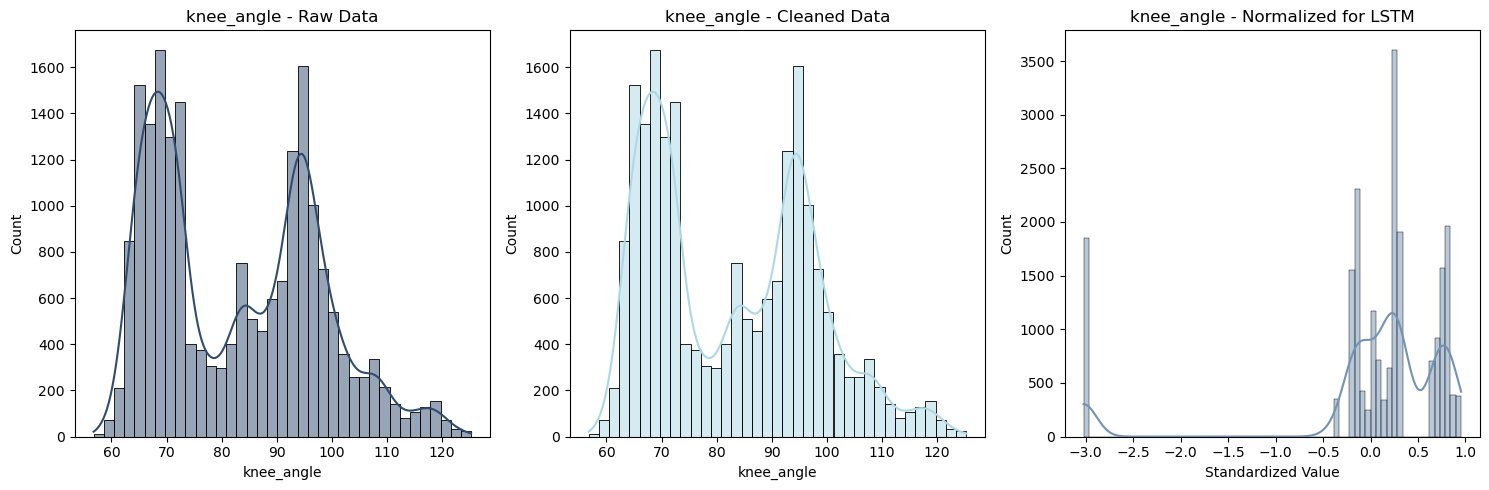

In [ ]:
# -----------------------------------------------------------------------------
#  Load the Three Data Sources
# -----------------------------------------------------------------------------
# Adjust these paths to match your actual files.

raw_path = "output/heel_exercise_data.pkl"       
cleaned_path = "output/final_cleaned_data_heel.pkl"  
reshaped_path = "output/lstm_sequences_heel.pkl"      

# Load the raw data 
raw_df = pd.read_pickle(raw_path)
print("Raw data loaded. Shape:", raw_df.shape)

# Load the cleaned data.
cleaned_df = pd.read_pickle(cleaned_path)
print("Cleaned data loaded. Shape:", cleaned_df.shape)

# Load the normalized LSTM sequences (3D array) and video IDs.
with open(reshaped_path, "rb") as f:
    X_normalized, video_ids = pkl.load(f)
print("LSTM sequences (normalized) loaded. Shape:", X_normalized.shape)
print("Number of video sequences:", len(video_ids))

# -----------------------------------------------------------------------------
#  Flatten the Normalized LSTM Data for Visualization
# -----------------------------------------------------------------------------
# X_normalized is a 3D array of shape (num_videos, sequence_length, num_features).
# Flatten to 2D to treat it like a DataFrame for quick histogram plotting.

num_videos, seq_len, num_features = X_normalized.shape
X_flat = X_normalized.reshape(-1, num_features)

normalized_df = pd.DataFrame(X_flat)


# -----------------------------------------------------------------------------
#  Plot the Distribution of 'knee_angle' Across All Three Stages
# -----------------------------------------------------------------------------
feature = "knee_angle"  # Name of the column in raw_df and cleaned_df

# Safety check: ensure the feature is in raw_df and cleaned_df
if feature not in raw_df.columns:
    raise ValueError(f"'{feature}' is not in raw_df columns.")
if feature not in cleaned_df.columns:
    raise ValueError(f"'{feature}' is not in cleaned_df columns.")

plt.figure(figsize=(15, 5))

# Subplot 1: Raw Data
plt.subplot(1, 3, 1)
sns.histplot(raw_df[feature].dropna(), kde=True, color="#304C6E")
plt.title(f"{feature} - Raw Data", fontsize=12)
plt.xlabel(feature)
plt.ylabel("Count")

# Subplot 2: Cleaned Data
plt.subplot(1, 3, 2)
sns.histplot(cleaned_df[feature].dropna(), kde=True, color="lightblue")
plt.title(f"{feature} - Cleaned Data", fontsize=12)
plt.xlabel(feature)
plt.ylabel("Count")

# Subplot 3: Normalized Data 
plt.subplot(1, 3, 3)
sns.histplot(normalized_df.iloc[:, 5], kde=True, color="#7293B5")
plt.title(f"{feature} - Normalized for LSTM", fontsize=12)
plt.xlabel("Standardized Value")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


<h1 style="color: #002B5B;">2. LSTM Model Building, Training & Evaluation</h1>

<h3 style="color: #0F52BA;">2.1 LSTM Model Architecture</h3> 

In [245]:
# -----------------------------------------------------------------------------
# Function: build_lstm_model
# -----------------------------------------------------------------------------

def build_lstm_model(input_shape):
    """
    Build and compile an LSTM model for regression.
    
    Parameters:
        input_shape (tuple): The shape of each input sequence (sequence_length, num_features).
    
    Returns:
        tf.keras.Model: A compiled LSTM model.
    """
    model = Sequential()
    # Add an LSTM layer with 64 units.
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.2))
    # Dense layer with 32 units (ReLU activation).
    model.add(Dense(32, activation='relu'))
    # Output layer with one neuron for regression.
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Determine input shape from X_normalized.
input_shape = X_normalized.shape[1:]  # (sequence_length, num_features)
print("Input shape for the LSTM model:", input_shape)

Input shape for the LSTM model: (700, 112)


<h3 style="color: #0F52BA;">2.2 Model Training</h3> 

In [246]:
# -----------------------------------------------------------------------------
# k-Fold Cross Validation Setup and Training
# -----------------------------------------------------------------------------
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold = 1

val_losses = []
val_maes = []
train_losses = []
train_maes = []

batch_size = 4
epochs = 50

for train_idx, val_idx in kf.split(X_normalized):
    print(f"\nTraining Fold {fold}")
    X_train, X_val = X_normalized[train_idx], X_normalized[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    model = build_lstm_model(input_shape)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1,
                        callbacks=[early_stopping])
    
    eval_results = model.evaluate(X_val, y_val, verbose=0)
    print(f"Fold {fold} Evaluation: Validation Loss = {eval_results[0]:.4f}, Validation MAE = {eval_results[1]:.4f}")
    val_losses.append(eval_results[0])
    val_maes.append(eval_results[1])
    
    final_train_loss = history.history["loss"][-1]
    final_train_mae = history.history["mae"][-1]
    print(f"Fold {fold} Final Training Metrics: Loss = {final_train_loss:.4f}, MAE = {final_train_mae:.4f}")
    train_losses.append(final_train_loss)
    train_maes.append(final_train_mae)
    
    fold += 1

avg_val_loss = np.mean(val_losses)
avg_val_mae = np.mean(val_maes)
avg_train_loss = np.mean(train_losses)
avg_train_mae = np.mean(train_maes)
print("\nAverage Validation Loss across folds:", avg_val_loss)
print("Average Validation MAE across folds:", avg_val_mae)
print("Average Training Loss across folds:", avg_train_loss)
print("Average Training MAE across folds:", avg_train_mae)


Training Fold 1


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step - loss: 7884.9951 - mae: 88.5387 - val_loss: 6506.7329 - val_mae: 80.1593
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 369ms/step - loss: 7793.6572 - mae: 87.8942 - val_loss: 6319.8228 - val_mae: 79.0179
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - loss: 7514.1572 - mae: 86.4444 - val_loss: 6174.1016 - val_mae: 78.1091
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - loss: 7561.1338 - mae: 86.6921 - val_loss: 6043.4302 - val_mae: 77.2831
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - loss: 7411.7666 - mae: 85.7496 - val_loss: 5908.2915 - val_mae: 76.4172
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 393ms/step - loss: 7225.6909 - mae: 84.7275 - val_loss: 5778.3257 - val_mae: 75.5777
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - loss: 6723.9810 - mae: 81.7258 - val_loss: 5624.0859 - val_mae: 74.5535
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - loss: 6370.2305 - mae: 79.4871 - val_loss: 5460.8828 - val_mae: 73.4633
Epoch 9/

<h3 style="color: #0F52BA;">2.3 Evaluation Metrics</h3> 

In [280]:
print("\nAverage Validation Loss across folds:", np.mean(val_losses))
print("Average Validation MAE across folds:", np.mean(val_maes))
print("Average Training Loss across folds:", np.mean(train_losses))
print("Average Training MAE across folds:", np.mean(train_maes))


Average Validation Loss across folds: 229.71108779907226
Average Validation MAE across folds: 11.76448621749878
Average Training Loss across folds: 183.92597503662108
Average Training MAE across folds: 10.677199363708496


In [262]:
# save the model
model_save_path = "output/final_heel_model.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to output/final_heel_model.h5


<h3 style="color: #0F52BA;">2.4 Predicted vs Actual Accuracy</h3> 

Model loaded from output/final_heel_model.h5 and recompiled successfully.
LSTM sequences (normalized) loaded. Shape: (30, 700, 112)
Number of video sequences: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predictions shape: (30,)
Target vector (y) shape: (30,)


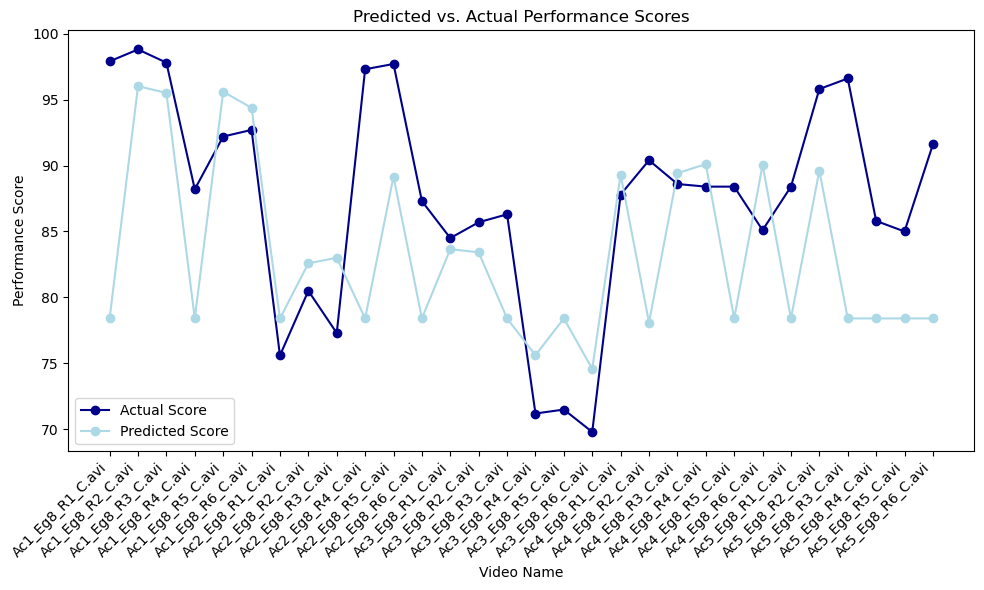

In [ ]:
# -----------------------------------------------------------------------------
#  Load the Saved Model
# -----------------------------------------------------------------------------
model_save_path = "output/final_heel_model.h5"  # Adjust this path if needed.
loaded_model = load_model(model_save_path, compile=False)
loaded_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(f"Model loaded from {model_save_path} and recompiled successfully.")

# -----------------------------------------------------------------------------
#  Load the Prepared LSTM Input Data
# -----------------------------------------------------------------------------
lstm_sequences_path = "output/lstm_sequences.pkl"
with open(lstm_sequences_path, "rb") as f:
    X_normalized, video_ids = pkl.load(f)
print("LSTM sequences (normalized) loaded. Shape:", X_normalized.shape)
print("Number of video sequences:", len(video_ids))

# -----------------------------------------------------------------------------
#  Define the Performance Scores Dictionary
# -----------------------------------------------------------------------------
# The performance scores for each video are mapped as follows:
video_scores = {
    "Ac1_Eg8_R1_C.avi": 97.9,
    "Ac1_Eg8_R2_C.avi": 98.8,
    "Ac1_Eg8_R3_C.avi": 97.8,
    "Ac1_Eg8_R4_C.avi": 88.2,
    "Ac1_Eg8_R5_C.avi": 92.2,
    "Ac1_Eg8_R6_C.avi": 92.7,
    "Ac2_Eg8_R1_C.avi": 75.6,
    "Ac2_Eg8_R2_C.avi": 80.5,
    "Ac2_Eg8_R3_C.avi": 77.3,
    "Ac2_Eg8_R4_C.avi": 97.3,
    "Ac2_Eg8_R5_C.avi": 97.7,
    "Ac2_Eg8_R6_C.avi": 87.3,
    "Ac3_Eg8_R1_C.avi": 84.5,
    "Ac3_Eg8_R2_C.avi": 85.7,
    "Ac3_Eg8_R3_C.avi": 86.3,
    "Ac3_Eg8_R4_C.avi": 71.2,
    "Ac3_Eg8_R5_C.avi": 71.5,
    "Ac3_Eg8_R6_C.avi": 69.8,
    "Ac4_Eg8_R1_C.avi": 87.8,
    "Ac4_Eg8_R2_C.avi": 90.4,
    "Ac4_Eg8_R3_C.avi": 88.6,
    "Ac4_Eg8_R4_C.avi": 88.4,
    "Ac4_Eg8_R5_C.avi": 88.4,
    "Ac4_Eg8_R6_C.avi": 85.1,
    "Ac5_Eg8_R1_C.avi": 88.4,
    "Ac5_Eg8_R2_C.avi": 95.8,
    "Ac5_Eg8_R3_C.avi": 96.6,
    "Ac5_Eg8_R4_C.avi": 85.8,
    "Ac5_Eg8_R5_C.avi": 85.0,
    "Ac5_Eg8_R6_C.avi": 91.6
}

# -----------------------------------------------------------------------------
#  Generate Predictions Using the Loaded Model
# -----------------------------------------------------------------------------
predictions = loaded_model.predict(X_normalized).flatten()  # Flatten to a 1D array
print("Predictions shape:", predictions.shape)

# -----------------------------------------------------------------------------
#  Construct the Target Vector (y) from the Performance Scores
# -----------------------------------------------------------------------------

y_true = np.array([video_scores.get(os.path.basename(video), 0) for video in video_ids])
print("Target vector (y) shape:", y_true.shape)

# -----------------------------------------------------------------------------
#  Visualization - Predicted vs. Actual Performance Scores
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 6))

# Plot actual performance scores
plt.plot(range(len(video_ids)), y_true, 'o-', color='darkblue', label="Actual Score")
# Plot predicted performance scores 
plt.plot(range(len(video_ids)), predictions, 'o-', color='lightblue', label="Predicted Score")

# Set x-axis tick labels to the video file names 
plt.xticks(range(len(video_ids)), [os.path.basename(video) for video in video_ids], rotation=45, ha='right')

plt.xlabel("Video Name")
plt.ylabel("Performance Score")
plt.title("Predicted vs. Actual Performance Scores")
plt.legend()
plt.tight_layout()
plt.show()
